In [372]:
import imp
import examples.models.romo as romo
import pycog
import numpy as np
import matplotlib.pyplot as plt
from jedi import jedi
from ipywidgets import interact, fixed
from sklearn.decomposition import PCA
from jedi.utils import plot, seedutil, func_generator, init_tools

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [18]:
reload(pycog)

<module 'pycog' from '/Users/simonhaxby/Code/Python/pycog/pycog/__init__.pyc'>

In [19]:
romo

<module 'examples.models.romo' from '/Users/simonhaxby/Code/Python/pycog/examples/models/romo.pyc'>

In [20]:
rng = np.random.RandomState(2)

In [21]:
params = {
    'callback_results': None,
    'target_output':    True,
    'minibatch_index':  1,
    'best_costs':       None,
    'name':             "gradient"
    }

In [605]:
trials = [romo.generate_trial(rng, 10, params) for _
          in range(20)]
trials[0]['epochs']

{'T': 4430.0,
 'decision': (4130.0, 4430.0),
 'delay': (600, 3630.0),
 'f1': (100, 600),
 'f2': (3630.0, 4130.0),
 'fixation': (0, 100)}

In [606]:
len(trials[0]['outputs'][:,1])

443

In [607]:
trials[0].keys()

['info', 'inputs', 'outputs', 'mask', 'epochs', 't']

(-0.5, 1.5)

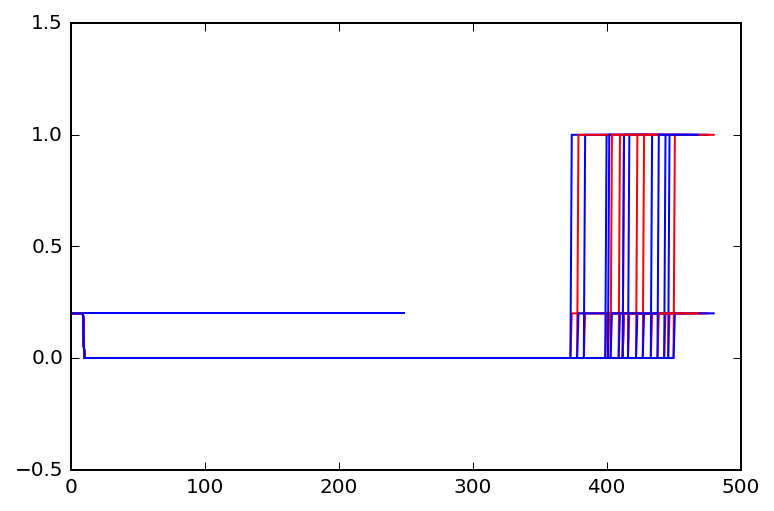

In [608]:
for trial in trials:
    plt.plot(range(len(trial['outputs'][:,1])), trial['outputs'][:,1],'r')
    plt.plot(range(len(trial['outputs'][:,0])), trial['outputs'][:,0], 'b')
plt.ylim(-.5,1.5)

(-0.5, 1.5)

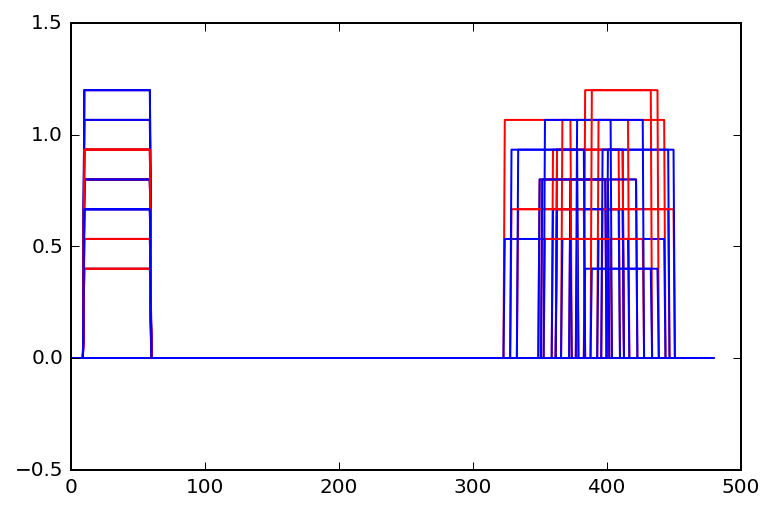

In [609]:
for trial in trials:
    plt.plot(range(len(trial['inputs'][:,1])), trial['inputs'][:,1], 'r')
    plt.plot(range(len(trial['inputs'][:,0])), trial['inputs'][:,0], 'b')
plt.ylim(-.5,1.5)

In [610]:
trial = trials[11]

(-50, 450.0)

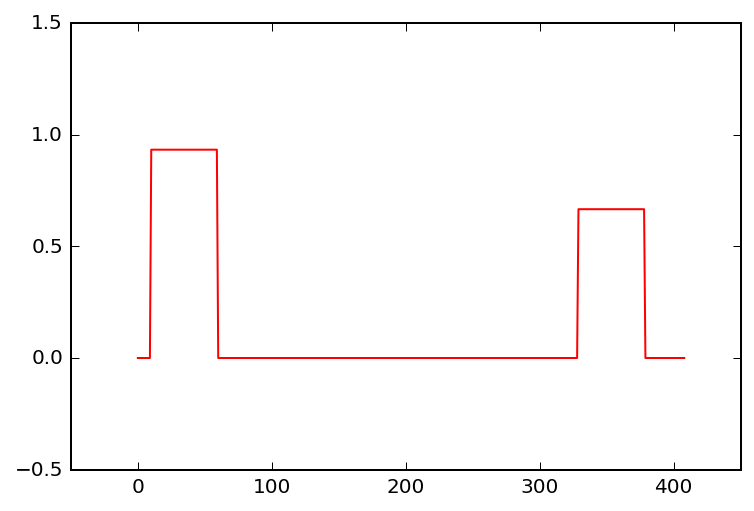

In [611]:
plt.plot(range(len(trial['inputs'][:,1])), trial['inputs'][:,1], 'r')
plt.ylim(-.5,1.5)
plt.xlim(-50,)

(-50, 450.0)

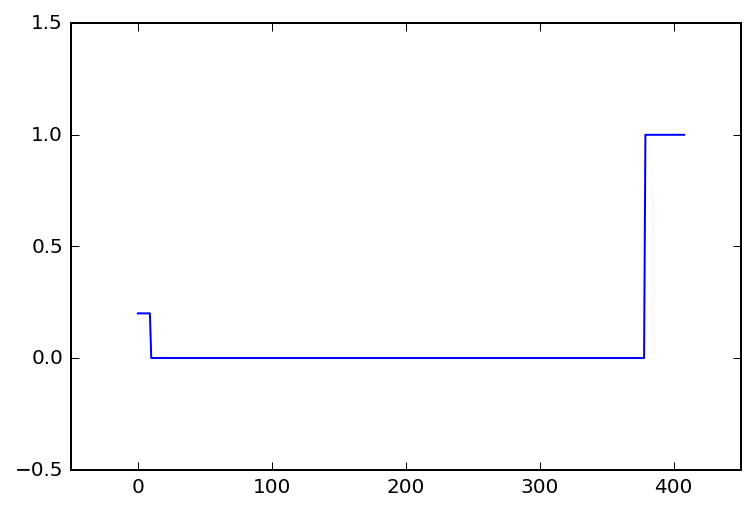

In [612]:
plt.plot(range(len(trial['outputs'][:,1])), trial['outputs'][:,1],'b')
plt.ylim(-.5,1.5)
plt.xlim(-50,)

In [630]:
means = []

In [665]:
# simulation parameters for FORCE
dt = .01      # time step
tstart = 0 # learning start time
tstop = 5  # learning stop time
rho = 1.25   # spectral radius of J
N = 500     # size of stochastic pool
lr = 1.0   # learning rate
pE = .8 # percent excitatory
sparsity = (.1,1,1) # sparsity
I = 1

In [668]:
errors = []
wus = []
zs = []
ts = []
xs = []
w_ = None
seedling = 25

J, Wz, Wi, x0, u, w = init_tools.set_simulation_parameters(seedling, N, I, pE=pE, p=sparsity, rho=rho)

for trial in trials[:10]:
    targets = trial['outputs'][:,1]
    inputs = trial['inputs'][:,1]
    tmax = float(len(targets))/100.-.01
    tstop = float(len(targets))/100.-.01
    
    if w_ is not None:
        w = w_
        x0 = x[-1]
    
    # inp & z are dummy variables
    def model(t0, x, params):
        i = params['index']
        tanh_x = params['tanh_x']
        z = params['z']
        inp = params['inputs'][i]
        return (-x + np.dot(J, tanh_x) + np.dot(Wi, inp) + Wz*z)/dt
    
    x, t, z, w_, wu, _ = jedi.force(targets, model, lr, dt, tmax, tstart, tstop, x0, w, 
                                    inputs=inputs)

    xs.append(x)
    zs.append(z)
    wus.append(wu)
    ts.append(t)
    
    error = np.abs(z[1:]-np.array(targets))
    errors.append(error)
    
errors = np.array(errors)

Simulation run-time (wall): 4.316 seconds
Simulation run-time (wall): 5.324 seconds
Simulation run-time (wall): 2.648 seconds
Simulation run-time (wall): 4.195 seconds
Simulation run-time (wall): 4.569 seconds
Simulation run-time (wall): 5.157 seconds
Simulation run-time (wall): 3.980 seconds
Simulation run-time (wall): 3.919 seconds
Simulation run-time (wall): 3.889 seconds
Simulation run-time (wall): 5.115 seconds


In [669]:
mean_error = np.mean(np.concatenate(errors))
means.append((mean_error, N, rho))
mean_error

0.01779044216076911

In [671]:
means 

[(0.018089823474718849, 600, 1.25),
 (0.020353481299425581, 600, 1.02),
 (0.022732102337748267, 300, 1.25),
 (0.021058296864862137, 500, 1.5),
 (0.01779044216076911, 500, 1.25)]

In [672]:
k = 0

1


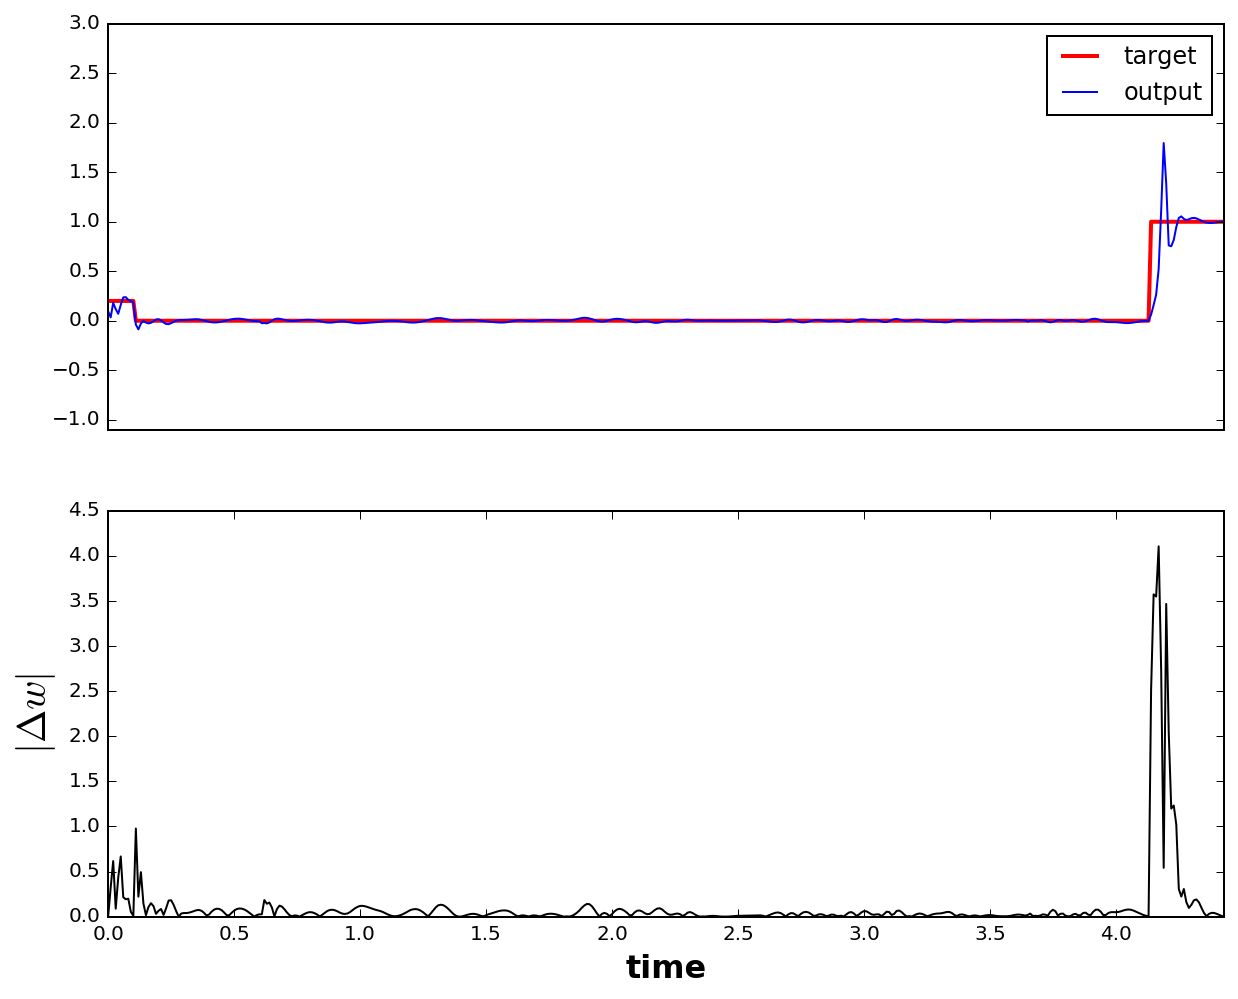

In [673]:
plt.figure(figsize=(10,8))
plot.target_vs_output_plus_error(ts[k], zs[k], wus[k], trials[k]['outputs'][:,1], offset=1, log=False)
k+=1
print(k)

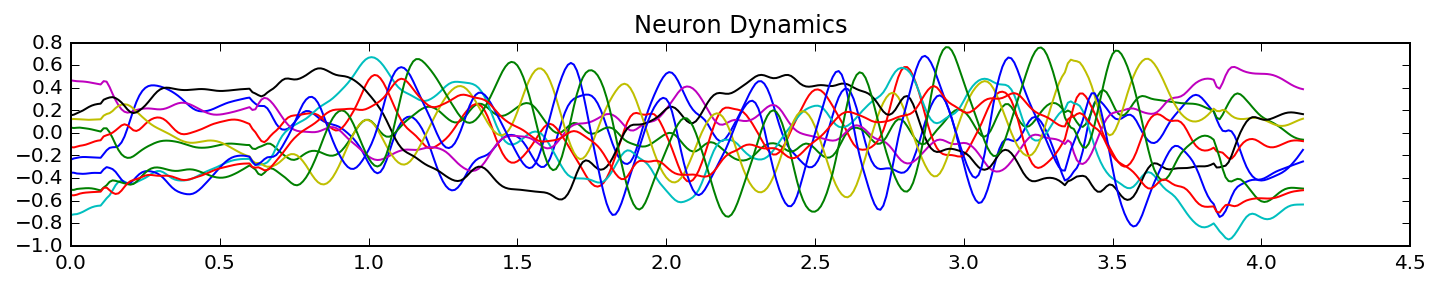

In [674]:
# Visualizing activities of first 20 neurons
T = 1000
plt.figure(figsize=(12,4))
plt.subplot(211)
plt.title("Neuron Dynamics");
for i in range(10):
    plt.plot(t[:T], x[:T, i]);

In [649]:
k = 0
X = np.concatenate([x for x in xs])

In [675]:
X.shape

(4225, 300)

In [676]:
pca = PCA(n_components=3)
pca_x = pca.fit_transform(X).T

In [677]:
T = [[0]]
for t in ts:
    T.append(t + T[-1][-1] + .01)
T = np.concatenate(T)[1:] - .01

In [678]:
pca_x.shape

(3, 4225)

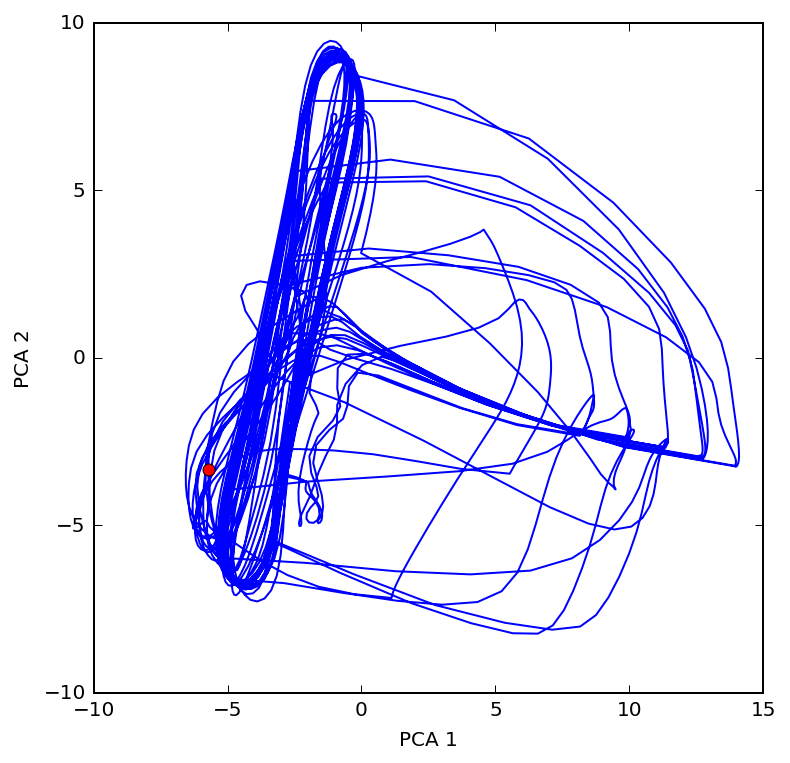

In [679]:
tmax = T[-1]
tmin = T[0]
tv = T

interact(plot.visualize_2dim_state, time=(tmin, tmax, .1), pca_x=fixed(pca_x), tv=fixed(tv));